In [ ]:
# default_exp learner

In [ ]:
#export
from fastai2.data.all import *
from fastai2.optimizer import *
from fastai2.callback.core import *

In [ ]:
from nbdev.showdoc import *

In [ ]:
#export
_all_ = ['CancelFitException', 'CancelEpochException', 'CancelTrainException', 'CancelValidException', 'CancelBatchException']

In [ ]:
#export
_loop = ['Start Fit', 'begin_fit', 'Start Epoch Loop', 'begin_epoch', 'Start Train', 'begin_train',
         'Start Batch Loop', 'begin_batch', 'after_pred', 'after_loss', 'after_backward',
         'after_step', 'after_cancel_batch', 'after_batch','End Batch Loop','End Train',
         'after_cancel_train', 'after_train', 'Start Valid', 'begin_validate','Start Batch Loop',
         '**CBs same as train batch**', 'End Batch Loop', 'End Valid', 'after_cancel_validate',
         'after_validate', 'End Epoch Loop', 'after_cancel_epoch', 'after_epoch', 'End Fit',
         'after_cancel_fit', 'after_fit']

# Learner

> Basic class for handling the training loop

We'll use the following for testing purposes (a basic linear regression problem):

In [ ]:
from torch.utils.data import TensorDataset

def synth_dbunch(a=2, b=3, bs=16, n_train=10, n_valid=2, cuda=False):
    def get_data(n):
        x = torch.randn(int(bs*n))
        return TensorDataset(x, a*x + b + 0.1*torch.randn(int(bs*n)))
    train_ds = get_data(n_train)
    valid_ds = get_data(n_valid)
    device = default_device() if cuda else None
    train_dl = TfmdDL(train_ds, bs=bs, shuffle=True, num_workers=0)
    valid_dl = TfmdDL(valid_ds, bs=bs, num_workers=0)
    return DataLoaders(train_dl, valid_dl, device=device)

class RegModel(Module):
    def __init__(self): self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
    def forward(self, x): return x*self.a + self.b

## Learner -

In [ ]:
# export
defaults.lr = 1e-3

In [ ]:
# export
def replacing_yield(o, attr, val):
    "Context manager to temporarily replace an attribute"
    old = getattr(o,attr)
    try:     yield setattr(o,attr,val)
    finally: setattr(o,attr,old)

In [ ]:
#export
def mk_metric(m):
    "Convert `m` to an `AvgMetric`, unless it's already a `Metric`"
    return m if isinstance(m, Metric) else AvgMetric(m)

In [ ]:
#export
def save_model(file, model, opt, with_opt=True):
    "Save `model` to `file` along with `opt` (if available, and if `with_opt`)"
    if opt is None: with_opt=False
    state = get_model(model).state_dict()
    if with_opt: state = {'model': state, 'opt':opt.state_dict()}
    torch.save(state, file)

In [ ]:
# export
def load_model(file, model, opt, with_opt=None, device=None, strict=True):
    "Load `model` from `file` along with `opt` (if available, and if `with_opt`)"
    if isinstance(device, int): device = torch.device('cuda', device)
    elif device is None: device = 'cpu'
    state = torch.load(file, map_location=device)
    hasopt = set(state)=={'model', 'opt'}
    model_state = state['model'] if hasopt else state
    get_model(model).load_state_dict(model_state, strict=strict)
    if hasopt and ifnone(with_opt,True):
        try: opt.load_state_dict(state['opt'])
        except:
            if with_opt: warn("Could not load the optimizer state.")
    elif with_opt: warn("Saved filed doesn't contain an optimizer state.")

In [ ]:
# export
def _try_concat(o):
    try:    return torch.cat(o)
    except: return sum([L(o_[i,:] for i in range_of(o_)) for o_ in o], L())

In [ ]:
# export
from contextlib import ExitStack

In [ ]:
#export
_before_epoch = [event.begin_fit, event.begin_epoch]
_after_epoch  = [event.after_epoch, event.after_fit]

In [ ]:
# export
class Learner():
    def __init__(self, dls, model, loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=trainable_params, cbs=None,
                 metrics=None, path=None, model_dir='models', wd=None, wd_bn_bias=False, train_bn=True,
                 moms=(0.95,0.85,0.95)):
        store_attr(self, "dls,model,opt_func,lr,splitter,model_dir,wd,wd_bn_bias,train_bn,metrics,moms")
        self.training,self.create_mbar,self.logger,self.opt,self.cbs = False,True,print,None,L()
        if loss_func is None:
            loss_func = getattr(dls.train_ds, 'loss_func', None)
            assert loss_func is not None, "Could not infer loss function from the data, please pass a loss function."
        self.loss_func = loss_func
        self.path = path if path is not None else getattr(dls, 'path', Path('.'))
        self.add_cbs([(cb() if isinstance(cb, type) else cb) for cb in L(defaults.callbacks)+L(cbs)])
        self.model.to(self.dls.device)
        if hasattr(self.model, 'reset'): self.model.reset()
        self.epoch,self.n_epoch,self.loss = 0,1,tensor(0.)

    @property
    def metrics(self): return self._metrics
    @metrics.setter
    def metrics(self,v): self._metrics = L(v).map(mk_metric)

    def add_cbs(self, cbs): L(cbs).map(self.add_cb)
    def remove_cbs(self, cbs): L(cbs).map(self.remove_cb)
    def add_cb(self, cb):
        old = getattr(self, cb.name, None)
        assert not old or isinstance(old, type(cb)), f"self.{cb.name} already registered"
        cb.learn = self
        setattr(self, cb.name, cb)
        self.cbs.append(cb)
        return self

    def remove_cb(self, cb):
        cb.learn = None
        if hasattr(self, cb.name): delattr(self, cb.name)
        if cb in self.cbs: self.cbs.remove(cb)

    @contextmanager
    def added_cbs(self, cbs):
        self.add_cbs(cbs)
        yield
        self.remove_cbs(cbs)
        
    @contextmanager
    def removed_cbs(self, cbs):
        self.remove_cbs(cbs)
        yield self
        self.add_cbs(cbs)

    def ordered_cbs(self, cb_func): return [cb for cb in sort_by_run(self.cbs) if hasattr(cb, cb_func)]

    def __call__(self, event_name): L(event_name).map(self._call_one)
    def _call_one(self, event_name):
        assert hasattr(event, event_name)
        [cb(event_name) for cb in sort_by_run(self.cbs)]

    def _bn_bias_state(self, with_bias): return bn_bias_params(self.model, with_bias).map(self.opt.state)
    def create_opt(self):
        self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
        if not self.wd_bn_bias:
            for p in self._bn_bias_state(True ): p['do_wd'] = False
        if self.train_bn:
            for p in self._bn_bias_state(False): p['force_train'] = True

    def _split(self, b):
        i = getattr(self.dls, 'n_inp', 1 if len(b)==1 else len(b)-1)
        self.xb,self.yb = b[:i],b[i:]

    def all_batches(self):
        self.n_iter = len(self.dl)
        for o in enumerate(self.dl): self.one_batch(*o)

    def one_batch(self, i, b):
        self.iter = i
        try:
            self._split(b);                                  self('begin_batch')
            self.pred = self.model(*self.xb);                self('after_pred')
            if len(self.yb) == 0: return
            self.loss = self.loss_func(self.pred, *self.yb); self('after_loss')
            if not self.training: return
            self.loss.backward();                            self('after_backward')
            self.opt.step();                                 self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                         self('after_cancel_batch')
        finally:                                             self('after_batch')

    def _do_begin_fit(self, n_epoch):
        self.n_epoch,self.loss = n_epoch,tensor(0.);         self('begin_fit')

    def _do_epoch_train(self):
        try:
            self.dl = self.dls.train;                        self('begin_train')
            self.all_batches()
        except CancelTrainException:                         self('after_cancel_train')
        finally:                                             self('after_train')

    def _do_epoch_validate(self, ds_idx=1, dl=None):
        if dl is None: dl = self.dls[ds_idx]
        names = ['shuffle', 'drop_last']
        try:
            dl,old,has = change_attrs(dl, names, [False,False])
            self.dl = dl;                                    self('begin_validate')
            with torch.no_grad(): self.all_batches()
        except CancelValidException:                         self('after_cancel_validate')
        finally:
            dl,*_ = change_attrs(dl, names, old, has);       self('after_validate')

    def fit(self, n_epoch, lr=None, wd=None, cbs=None, reset_opt=False):
        with self.added_cbs(cbs):
            if reset_opt or not self.opt: self.create_opt()
            if wd is None: wd = self.wd
            if wd is not None: self.opt.set_hypers(wd=wd)
            self.opt.set_hypers(lr=self.lr if lr is None else lr)

            try:
                self._do_begin_fit(n_epoch)
                for epoch in range(n_epoch):
                    try:
                        self.epoch=epoch;          self('begin_epoch')
                        self._do_epoch_train()
                        self._do_epoch_validate()
                    except CancelEpochException:   self('after_cancel_epoch')
                    finally:                       self('after_epoch')

            except CancelFitException:             self('after_cancel_fit')
            finally:                               self('after_fit')

    def validate(self, ds_idx=1, dl=None, cbs=None):
        if dl is None: dl = self.dls[ds_idx]
        with self.added_cbs(cbs), self.no_logging(), self.no_mbar():
            self(_before_epoch)
            self._do_epoch_validate(ds_idx, dl)
            self(_after_epoch)
        return getattr(self, 'final_record', None)

    @delegates(GatherPredsCallback.__init__)
    def get_preds(self, ds_idx=1, dl=None, with_input=False, with_decoded=False, with_loss=False, act=None, 
                  inner=False, **kwargs):
        if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
        cb = GatherPredsCallback(with_input=with_input, with_loss=with_loss, **kwargs)
        #with self.no_logging(), self.added_cbs(cb), self.loss_not_reduced(), self.no_mbar():
        ctx_mgrs = [self.no_logging(), self.added_cbs(cb), self.no_mbar()]
        if with_loss: ctx_mgrs.append(self.loss_not_reduced())
        with ExitStack() as stack:
            for mgr in ctx_mgrs: stack.enter_context(mgr)
            self(event.begin_epoch if inner else _before_epoch)
            self._do_epoch_validate(dl=dl)
            self(event.after_epoch if inner else _after_epoch)
            if act is None: act = getattr(self.loss_func, 'activation', noop)
            res = cb.all_tensors()
            pred_i = 1 if with_input else 0
            if res[pred_i] is not None:
                res[pred_i] = act(res[pred_i])
                if with_decoded: res.insert(pred_i+2, getattr(self.loss_func, 'decodes', noop)(res[pred_i]))
            return tuple(res)

    def predict(self, item, rm_type_tfms=None, with_input=False):
        dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms)
        inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
        dec = self.dls.decode_batch((*tuplify(inp),*tuplify(dec_preds)))[0]
        i = getattr(self.dls, 'n_inp', -1)
        dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
        res = dec_targ,dec_preds[0],preds[0]
        if with_input: res = (dec_inp,) + res
        return res

    def show_results(self, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
        if dl is None: dl = self.dls[ds_idx].new(shuffle=shuffle)
        b = dl.one_batch()
        _,_,preds = self.get_preds(dl=[b], with_decoded=True)
        self.dls.show_results(b, preds, max_n=max_n, **kwargs)

    def show_training_loop(self):
        indent = 0
        for s in _loop:
            if s.startswith('Start'): print(f'{" "*indent}{s}'); indent += 2
            elif s.startswith('End'): indent -= 2; print(f'{" "*indent}{s}')
            else: print(f'{" "*indent} - {s:15}:', self.ordered_cbs(s))

    @contextmanager
    def no_logging(self): return replacing_yield(self, 'logger', noop)
    @contextmanager
    def no_mbar(self):    return replacing_yield(self, 'create_mbar', False)

    @contextmanager
    def loss_not_reduced(self):
        if hasattr(self.loss_func, 'reduction'): return replacing_yield(self.loss_func, 'reduction', 'none')
        else: return replacing_yield(self, 'loss_func', partial(self.loss_func, reduction='none'))

    def save(self, file, with_opt=True):
        if rank_distrib(): return # don't save if slave proc
        file = join_path_file(file, self.path/self.model_dir, ext='.pth')
        save_model(file, self.model, getattr(self,'opt',None), with_opt)

    def load(self, file, with_opt=None, device=None, strict=True):
        if device is None: device = self.dls.device
        if self.opt is None: self.create_opt()
        distrib_barrier()
        file = join_path_file(file, self.path/self.model_dir, ext='.pth')
        load_model(file, self.model, self.opt, with_opt=with_opt, device=device, strict=strict)
        return self

Learner.x,Learner.y = add_props(lambda i,x: detuplify((x.xb,x.yb)[i]))

In [ ]:
#export
add_docs(Learner, "Group together a `model`, some `dls` and a `loss_func` to handle training",
    add_cbs="Add `cbs` to the list of `Callback` and register `self` as their learner",
    add_cb="Add `cb` to the list of `Callback` and register `self` as their learner",
    remove_cbs="Remove `cbs` from the list of `Callback` and deregister `self` as their learner",
    remove_cb="Add `cb` from the list of `Callback` and deregister `self` as their learner",
    added_cbs="Context manage that temporarily adds `cbs`",
    removed_cbs="Context manage that temporarily removes `cbs`",
    ordered_cbs="Return a list of `Callback` for one step `cb_func` in the training loop",
    create_opt="Create an optimizer with `lr`",
    one_batch="Train or evaluate `self.model` on batch `(xb,yb)`",
    all_batches="Train or evaluate `self.model` on all batches of `self.dl`",
    fit="Fit `self.model` for `n_epoch` using `cbs`. Optionally `reset_opt`.",
    validate="Validate on `dl` with potential new `cbs`.",
    get_preds="Get the predictions and targets on the `ds_idx`-th dbunchset or `dl`, optionally `with_input` and `with_loss`",
    predict="Return the prediction on `item`, fully decoded, loss function decoded and probabilities",
    show_results="Show some predictions on `ds_idx`-th dbunchset or `dl`",
    show_training_loop="Show each step in the training loop",
    no_logging="Context manager to temporarily remove `logger`",
    no_mbar="Context manager to temporarily prevent the master progress bar from being created",
    loss_not_reduced="A context manager to evaluate `loss_func` with reduction set to none.",
    save="Save model and optimizer state (if `with_opt`) to `self.path/self.model_dir/file`",
    load="Load model and optimizer state (if `with_opt`) from `self.path/self.model_dir/file` using `device`"
)

`opt_func` will be used to create an optimizer when `Learner.fit` is called, with `lr` as a learning rate. `splitter` is a function taht takes `self.model` and returns a list of parameter groups (or just one parameter group if there are no different parameter groups). The default is `trainable_params`, which returns all trainable parameters of the model.

`cbs` is one or a list of `Callback`s  to pass to the `Learner`. Each `Callback` is registered as an attribute of `Learner` (with camel case). At creation, all the callbacks in `defaults.callbacks` (`TrainEvalCallback` and `Recorder`) are associated to the `Learner`.

`metrics` is an optional list of metrics, that can be either functions or `Metric`s (see below).

### Training loop

In [ ]:
#Test init with callbacks
class TstCallback(Callback):
    def batch_begin(self): self.learn.a = self.a + 1

def synth_learner(n_train=10, n_valid=2, cuda=False, lr=defaults.lr, **kwargs):
    data = synth_dbunch(n_train=n_train,n_valid=n_valid, cuda=cuda)
    return Learner(data, RegModel(), loss_func=MSELossFlat(), lr=lr, **kwargs)

tst_learn = synth_learner()
test_eq(len(tst_learn.cbs), 1)
assert isinstance(tst_learn.cbs[0], TrainEvalCallback)
assert hasattr(tst_learn, ('train_eval'))

tst_learn = synth_learner(cbs=TstCallback())
test_eq(len(tst_learn.cbs), 2)
assert isinstance(tst_learn.cbs[1], TstCallback)
assert hasattr(tst_learn, ('tst'))

tst_learn = synth_learner(cbs=TstCallback)
test_eq(len(tst_learn.cbs), 2)
assert isinstance(tst_learn.cbs[1], TstCallback)
assert hasattr(tst_learn, ('tst'))

#A name that becomes an existing attribute of the Learner will throw an exception (here add_cb)
class AddCbCallback(Callback): pass
test_fail(lambda: synth_learner(cbs=AddCbCallback()))

In [ ]:
show_doc(Learner.fit)

<h4 id="Learner.fit" class="doc_header"><code>Learner.fit</code><a href="__main__.py#L108" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.fit</code>(**`n_epoch`**, **`lr`**=*`None`*, **`wd`**=*`None`*, **`cbs`**=*`None`*, **`reset_opt`**=*`False`*)

Fit `self.model` for `n_epoch` using `cbs`. Optionally `reset_opt`.

In [ ]:
#Training a few epochs should make the model better
learn = synth_learner(cbs=TstCallback, lr=1e-2)
learn.model = learn.model.cpu()
xb,yb = learn.dls.one_batch()
init_loss = learn.loss_func(learn.model(xb), yb)
learn.fit(6)
assert learn.loss < init_loss

In [ ]:
#hide
#Test of TrainEvalCallback
class TestTrainEvalCallback(Callback):
    run_after,run_valid = TrainEvalCallback,False
    def begin_fit(self): 
        test_eq([self.pct_train,self.train_iter], [0., 0])
        self.old_pct_train,self.old_train_iter = self.pct_train,self.train_iter
    
    def begin_batch(self): test_eq(next(self.model.parameters()).device, find_device(self.xb))
    
    def after_batch(self):
        assert self.training
        test_eq(self.pct_train , self.old_pct_train+1/(self.n_iter*self.n_epoch))
        test_eq(self.train_iter, self.old_train_iter+1)
        self.old_pct_train,self.old_train_iter = self.pct_train,self.train_iter
    
    def begin_train(self):
        assert self.training and self.model.training
        test_eq(self.pct_train, self.epoch/self.n_epoch)
        self.old_pct_train = self.pct_train
    
    def begin_validate(self):
        assert not self.training and not self.model.training
        
learn = synth_learner(cbs=TestTrainEvalCallback)
learn.fit(1)
#Check order is properly taken into account
learn.cbs = L(reversed(learn.cbs))

In [ ]:
#hide
#cuda
#Check model is put on the GPU if needed
learn = synth_learner(cbs=TestTrainEvalCallback, cuda=True)
learn.fit(1)

In [ ]:
#hide
#Check wd is not applied on bn/bias when option wd_bn_bias=False
class _TstModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
        self.tst = nn.Sequential(nn.Linear(4,5), nn.BatchNorm1d(3))
        self.tst[0].bias.data,self.tst[1].bias.data = torch.randn(5),torch.randn(3) 
    def forward(self, x): return x * self.a + self.b
    
class _PutGrad(Callback):
    def after_backward(self):
        for p in self.learn.model.tst.parameters():
            p.grad = torch.ones_like(p.data)
    
learn = synth_learner(n_train=5, opt_func = partial(SGD, wd=1, decouple_wd=True), cbs=_PutGrad)
learn.model = _TstModel()
init = [p.clone() for p in learn.model.tst.parameters()]
learn.fit(1, lr=1e-2)
end = list(learn.model.tst.parameters())
for i in [0]: assert not torch.allclose(end[i]-init[i], -0.05 * torch.ones_like(end[i]))
for i in [1,2,3]: test_close(end[i]-init[i], -0.05 * torch.ones_like(end[i]))

In [ ]:
show_doc(Learner.one_batch)

<h4 id="Learner.one_batch" class="doc_header"><code>Learner.one_batch</code><a href="__main__.py#L73" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.one_batch</code>(**`i`**, **`b`**)

Train or evaluate `self.model` on batch `(xb,yb)`

This is an internal method called by `Learner.fit`. If passed, `i` is the index of this iteration in the epoch. In training method, this does a full training step on the batch (compute predictions, loss, gradients, update the model parameters and zero the gradients). In validation mode, it stops at the loss computation.

In [ ]:
# export
class VerboseCallback(Callback):
    "Callback that prints the name of each event called"
    def __call__(self, event_name):
        print(event_name)
        super().__call__(event_name)

In [ ]:
#hide
class TestOneBatch(VerboseCallback):
    def __init__(self, xb, yb, i):
        self.save_xb,self.save_yb,self.i = xb,yb,i
        self.old_pred,self.old_loss = None,tensor(0.)
        
    def begin_batch(self):
        self.old_a,self.old_b = self.model.a.data.clone(),self.model.b.data.clone()
        test_eq(self.iter,    self.i)
        test_eq(self.save_xb, *self.xb)
        test_eq(self.save_yb, *self.yb)
        if hasattr(self.learn, 'pred'): test_eq(self.pred, self.old_pred)
    
    def after_pred(self):
        self.old_pred = self.pred
        test_eq(self.pred, self.model.a.data * self.x + self.model.b.data)
        test_eq(self.loss, self.old_loss)
    
    def after_loss(self):
        self.old_loss = self.loss
        test_eq(self.loss, self.loss_func(self.old_pred, self.save_yb))
        for p in self.model.parameters(): 
            if not hasattr(p, 'grad') or p.grad is not None: test_eq(p.grad, tensor([0.]))
    
    def after_backward(self):
        self.grad_a = (2 * self.x * (self.pred.data - self.y)).mean()
        self.grad_b = 2 * (self.pred.data - self.y).mean()
        test_close(self.model.a.grad.data, self.grad_a)
        test_close(self.model.b.grad.data, self.grad_b)
        test_eq(self.model.a.data, self.old_a)
        test_eq(self.model.b.data, self.old_b)
        
    def after_step(self):
        test_close(self.model.a.data, self.old_a - self.lr * self.grad_a)
        test_close(self.model.b.data, self.old_b - self.lr * self.grad_b)
        self.old_a,self.old_b = self.model.a.data.clone(),self.model.b.data.clone()
        test_close(self.model.a.grad.data, self.grad_a)
        test_close(self.model.b.grad.data, self.grad_b)
    
    def after_batch(self):
        for p in self.model.parameters(): test_eq(p.grad, tensor([0.]))

In [ ]:
#hide
learn = synth_learner()
b = learn.dls.one_batch()
learn = synth_learner(cbs=TestOneBatch(*b, 42), lr=1e-2)
#Remove train/eval
learn.cbs = learn.cbs[1:]
#Setup
learn.loss,learn.training = tensor(0.),True
learn.opt = SGD(learn.model.parameters(), lr=learn.lr)
learn.model.train()
batch_events = ['begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step', 'after_batch']
test_stdout(lambda: learn.one_batch(42, b), '\n'.join(batch_events))
test_stdout(lambda: learn.one_batch(42, b), '\n'.join(batch_events)) #Check it works for a second batch

In [ ]:
show_doc(Learner.all_batches)

<h4 id="Learner.all_batches" class="doc_header"><code>Learner.all_batches</code><a href="__main__.py#L69" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.all_batches</code>()

Train or evaluate `self.model` on all batches of `self.dl`

In [ ]:
#hide
learn = synth_learner(n_train=5, cbs=VerboseCallback())
learn.opt = SGD(learn.model.parameters(), lr=learn.lr)
with redirect_stdout(io.StringIO()): 
    learn._do_begin_fit(1)
    learn.epoch,learn.dl = 0,learn.dls.train
    learn('begin_epoch')
    learn('begin_train')
test_stdout(learn.all_batches, '\n'.join(batch_events * 5))
test_eq(learn.train_iter, 5)

valid_events = ['begin_batch', 'after_pred', 'after_loss', 'after_batch']
with redirect_stdout(io.StringIO()): 
    learn.dl = learn.dls.valid
    learn('begin_validate')
test_stdout(learn.all_batches, '\n'.join(valid_events * 2))
test_eq(learn.train_iter, 5)

In [ ]:
#hide
learn = synth_learner(n_train=5, cbs=VerboseCallback())
test_stdout(lambda: learn._do_begin_fit(42), 'begin_fit')
test_eq(learn.n_epoch, 42)
test_eq(learn.loss, tensor(0.))

In [ ]:
#hide
learn.opt = SGD(learn.model.parameters(), lr=learn.lr)
learn.epoch = 0
test_stdout(lambda: learn._do_epoch_train(), '\n'.join(['begin_train'] + batch_events * 5 + ['after_train']))

In [ ]:
#hide
test_stdout(learn._do_epoch_validate, '\n'.join(['begin_validate'] + valid_events * 2+ ['after_validate']))

### Serializing

In [ ]:
show_doc(Learner.save)

<h4 id="Learner.save" class="doc_header"><code>Learner.save</code><a href="__main__.py#L190" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.save</code>(**`file`**, **`with_opt`**=*`True`*)

Save model and optimizer state (if `with_opt`) to `self.path/self.model_dir/file`

`file` can be a `Path`, a `string` or a buffer.

In [ ]:
show_doc(Learner.load)

<h4 id="Learner.load" class="doc_header"><code>Learner.load</code><a href="__main__.py#L195" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.load</code>(**`file`**, **`with_opt`**=*`None`*, **`device`**=*`None`*, **`strict`**=*`True`*)

Load model and optimizer state (if `with_opt`) from `self.path/self.model_dir/file` using `device`

`file` can be a `Path`, a `string` or a buffer. Use `device` to load the model/optimizer state on a device different from the one it was saved.

In [ ]:
learn = synth_learner(cbs=TstCallback, opt_func=partial(SGD, mom=0.9))
xb,yb = learn.dls.one_batch()
init_loss = learn.loss_func(learn.model(xb), yb)
learn.fit(1)
learn.save('tmp')
assert (Path.cwd()/'models/tmp.pth').exists()

learn1 = synth_learner(cbs=TstCallback, opt_func=partial(SGD, mom=0.9))
learn1 = learn1.load('tmp')
test_eq(learn.model.a, learn1.model.a)
test_eq(learn.model.b, learn1.model.b)
test_eq(learn.opt.state_dict(), learn1.opt.state_dict())

learn.save('tmp1', with_opt=False)
learn1 = synth_learner(cbs=TstCallback, opt_func=partial(SGD, mom=0.9))
learn1 = learn1.load('tmp1')
test_eq(learn.model.a, learn1.model.a)
test_eq(learn.model.b, learn1.model.b)
test_ne(learn.opt.state_dict(), learn1.opt.state_dict())

shutil.rmtree('models')

### Callback handling

In [ ]:
show_doc(Learner.__call__)

<h4 id="Learner.__call__" class="doc_header"><code>Learner.__call__</code><a href="__main__.py#L52" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.__call__</code>(**`event_name`**)

Call self as a function.

In [ ]:
show_doc(Learner.add_cb)

<h4 id="Learner.add_cb" class="doc_header"><code>Learner.add_cb</code><a href="__main__.py#L25" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.add_cb</code>(**`cb`**)

Add `cb` to the list of [`Callback`](/callback.core#Callback) and register `self` as their learner

In [ ]:
learn = synth_learner()
learn.add_cb(TestTrainEvalCallback())
test_eq(len(learn.cbs), 2)
assert isinstance(learn.cbs[1], TestTrainEvalCallback)
test_eq(learn.train_eval.learn, learn)

In [ ]:
show_doc(Learner.add_cbs)

<h4 id="Learner.add_cbs" class="doc_header"><code>Learner.add_cbs</code><a href="__main__.py#L23" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.add_cbs</code>(**`cbs`**)

Add `cbs` to the list of [`Callback`](/callback.core#Callback) and register `self` as their learner

In [ ]:
learn.add_cbs([TestTrainEvalCallback(), TestTrainEvalCallback()])
test_eq(len(learn.cbs), 4)

In [ ]:
show_doc(Learner.remove_cb)

<h4 id="Learner.remove_cb" class="doc_header"><code>Learner.remove_cb</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.remove_cb</code>(**`cb`**)

Add `cb` from the list of [`Callback`](/callback.core#Callback) and deregister `self` as their learner

In [ ]:
cb = learn.cbs[1]
learn.remove_cb(learn.cbs[1])
test_eq(len(learn.cbs), 3)
assert cb.learn is None
assert not getattr(learn,'test_train_eval',None)

In [ ]:
show_doc(Learner.remove_cbs)

<h4 id="Learner.remove_cbs" class="doc_header"><code>Learner.remove_cbs</code><a href="__main__.py#L24" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.remove_cbs</code>(**`cbs`**)

Remove `cbs` from the list of [`Callback`](/callback.core#Callback) and deregister `self` as their learner

In [ ]:
cb = learn.cbs[1]
learn.remove_cbs(learn.cbs[1:])
test_eq(len(learn.cbs), 1)

When writing a callback, the following attributes of `Learner` are available:
- `model`: the model used for training/validation
- `data`: the underlying `DataLoaders`
- `loss_func`: the loss function used
- `opt`: the optimizer used to udpate the model parameters
- `opt_func`: the function used to create the optimizer
- `cbs`: the list containing all `Callback`s
- `dl`: current `DataLoader` used for iteration
- `x`/`xb`: last input drawn from `self.dl` (potentially modified by callbacks). `xb` is always a tuple (potentially with one element) and `x` is detuplified. You can only assign to `xb`.
- `y`/`yb`: last target drawn from `self.dl` (potentially modified by callbacks). `yb` is always a tuple (potentially with one element) and `y` is detuplified. You can only assign to `yb`.
- `pred`: last predictions from `self.model` (potentially modified by callbacks)
- `loss`: last computed loss (potentially modified by callbacks)
- `n_epoch`: the number of epochs in this training
- `n_iter`: the number of iterations in the current `self.dl`
- `epoch`: the current epoch index (from 0 to `n_epoch-1`)
- `iter`: the current iteration index in `self.dl` (from 0 to `n_iter-1`)

The following attributes are added by `TrainEvalCallback` and should be available unless you went out of your way to remove that callback:

- `train_iter`: the number of training iterations done since the beginning of this training
- `pct_train`: from 0. to 1., the percentage of training iterations completed
- `training`:  flag to indicate if we're in training mode or not

The following attribute is added by `Recorder` and should be available unless you went out of your way to remove that callback:

- `smooth_loss`: an exponentially-averaged version of the training loss

### Control flow testing

In [ ]:
#hide
batch_events  = ['begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step', 'after_batch']
batchv_events = ['begin_batch', 'after_pred', 'after_loss', 'after_batch']
train_events  = ['begin_train']    + batch_events  + ['after_train']
valid_events  = ['begin_validate'] + batchv_events + ['after_validate']
epoch_events  = ['begin_epoch'] + train_events + valid_events + ['after_epoch']
cycle_events  = ['begin_fit'] + epoch_events + ['after_fit']

In [ ]:
#hide
learn = synth_learner(n_train=1, n_valid=1)
test_stdout(lambda: learn.fit(1, cbs=VerboseCallback()), '\n'.join(cycle_events))

In [ ]:
#hide
class TestCancelCallback(VerboseCallback):
    def __init__(self, cancel_at=event.begin_batch, exception=CancelBatchException, train=None):
        def _interrupt(): 
            if train is None or train == self.training: raise exception()
        setattr(self, cancel_at, _interrupt)

In [ ]:
#hide
#test cancel batch
for i,e in enumerate(batch_events[:-1]):
    be = batch_events[:i+1] + ['after_cancel_batch', 'after_batch']
    bev = be if i <3 else batchv_events
    cycle = cycle_events[:3] + be + ['after_train', 'begin_validate'] + bev + cycle_events[-3:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(cancel_at=e)), '\n'.join(cycle))

#CancelBatchException not caught if thrown in any other event
for e in cycle_events:
    if e not in batch_events[:-1]:
        with redirect_stdout(io.StringIO()):
            cb = TestCancelCallback(cancel_at=e)
            test_fail(lambda: learn.fit(1, cbs=cb))
            learn.remove_cb(cb) #Have to remove it manually

In [ ]:
#hide
#test cancel train
for i,e in enumerate(['begin_train'] + batch_events):
    be = batch_events[:i] + (['after_batch'] if i >=1 and i < len(batch_events) else []) 
    be += ['after_cancel_train', 'after_train']
    cycle = cycle_events[:3] + be + ['begin_validate'] + batchv_events + cycle_events[-3:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelTrainException, True)), '\n'.join(cycle))

#CancelTrainException not caught if thrown in any other event
for e in cycle_events:
    if e not in ['begin_train'] + batch_events[:-1]:
        with redirect_stdout(io.StringIO()):
            cb = TestCancelCallback(e, CancelTrainException)
            test_fail(lambda: learn.fit(1, cbs=cb))
            learn.remove_cb(cb) #Have to remove it manually  

In [ ]:
#hide
#test cancel valid
for i,e in enumerate(['begin_validate'] + batchv_events):
    bev = batchv_events[:i] + (['after_batch'] if i >=1 and i < len(batchv_events) else []) + ['after_cancel_validate']
    cycle = cycle_events[:3] + batch_events + ['after_train', 'begin_validate'] + bev + cycle_events[-3:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelValidException, False)), '\n'.join(cycle))
    
#CancelValidException not caught if thrown in any other event
for e in cycle_events:
    if e not in ['begin_validate'] + batch_events[:3]:
        with redirect_stdout(io.StringIO()):
            cb = TestCancelCallback(e, CancelValidException)
            test_fail(lambda: learn.fit(1, cbs=cb))
            learn.remove_cb(cb) #Have to remove it manually  

In [ ]:
#hide
#test cancel epoch
#In train
for i,e in enumerate(['begin_train'] + batch_events):
    be = batch_events[:i] + (['after_batch'] if i >=1 and i<len(batch_events) else []) 
    cycle = cycle_events[:3] + be + ['after_train', 'after_cancel_epoch'] + cycle_events[-2:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelEpochException, True)), '\n'.join(cycle))

#In valid
for i,e in enumerate(['begin_validate'] + batchv_events):
    bev = batchv_events[:i] + (['after_batch'] if i >=1 and i<len(batchv_events) else [])
    cycle = cycle_events[:3] + batch_events + ['after_train', 'begin_validate'] + bev 
    cycle += ['after_validate', 'after_cancel_epoch'] + cycle_events[-2:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelEpochException, False)), '\n'.join(cycle))

#In begin epoch
test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback('begin_epoch', CancelEpochException, False)), 
            '\n'.join(cycle_events[:2] + ['after_cancel_epoch'] + cycle_events[-2:]))

#CancelEpochException not caught if thrown in any other event
for e in ['begin_fit', 'after_epoch', 'after_fit']:
    if e not in ['begin_validate'] + batch_events[:3]:
        with redirect_stdout(io.StringIO()):
            cb = TestCancelCallback(e, CancelEpochException)
            test_fail(lambda: learn.fit(1, cbs=cb))
            learn.remove_cb(cb) #Have to remove it manually  

In [ ]:
#hide
#test cancel fit
#In begin fit
test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback('begin_fit', CancelFitException)), 
            '\n'.join(['begin_fit', 'after_cancel_fit', 'after_fit']))

#In begin epoch
test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback('begin_epoch', CancelFitException, False)), 
            '\n'.join(cycle_events[:2] + ['after_epoch', 'after_cancel_fit', 'after_fit']))
#In train
for i,e in enumerate(['begin_train'] + batch_events):
    be = batch_events[:i] + (['after_batch'] if i >=1 and i<len(batch_events) else []) 
    cycle = cycle_events[:3] + be + ['after_train', 'after_epoch', 'after_cancel_fit', 'after_fit']
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelFitException, True)), '\n'.join(cycle))
    
#In valid
for i,e in enumerate(['begin_validate'] + batchv_events):
    bev = batchv_events[:i] + (['after_batch'] if i >=1 and i<len(batchv_events) else [])
    cycle = cycle_events[:3] + batch_events + ['after_train', 'begin_validate'] + bev 
    cycle += ['after_validate', 'after_epoch', 'after_cancel_fit', 'after_fit']
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelFitException, False)), '\n'.join(cycle))
    
#CancelEpochException not caught if thrown in any other event
with redirect_stdout(io.StringIO()):
    cb = TestCancelCallback('after_fit', CancelEpochException)
    test_fail(lambda: learn.fit(1, cbs=cb))
    learn.remove_cb(cb) #Have to remove it manually  

## Metrics -

In [ ]:
#export
@docs
class Metric():
    "Blueprint for defining a metric"
    def reset(self): pass
    def accumulate(self, learn): pass
    @property
    def value(self): raise NotImplementedError

    @property
    def name(self): return class2attr(self, 'Metric')

    _docs = dict(
        reset="Reset inner state to prepare for new computation",
        name="Name of the `Metric`, camel-cased and with Metric removed",
        accumulate="Use `learn` to update the state with new results",
        value="The value of the metric")

In [ ]:
show_doc(Metric, title_level=3)

<h3 id="Metric" class="doc_header"><code>class</code> <code>Metric</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>Metric</code>()

Blueprint for defining a metric

Metrics can be simple averages (like accuracy) but sometimes their computation is a little bit more complex and can't be averaged over batches (like precision or recall), which is why we need a special class for them. For simple functions that can be computed as averages over batches, we can use the class `AvgMetric`, otherwise you'll need to implement the following methods.

> Note: If your <code>Metric</code> has state depending on tensors, don't forget to store it on the CPU to avoid any potential memory leaks.

In [ ]:
show_doc(Metric.reset)

<h4 id="Metric.reset" class="doc_header"><code>Metric.reset</code><a href="__main__.py#L5" class="source_link" style="float:right">[source]</a></h4>

> <code>Metric.reset</code>()

Reset inner state to prepare for new computation

In [ ]:
show_doc(Metric.accumulate)

<h4 id="Metric.accumulate" class="doc_header"><code>Metric.accumulate</code><a href="__main__.py#L6" class="source_link" style="float:right">[source]</a></h4>

> <code>Metric.accumulate</code>(**`learn`**)

Use `learn` to update the state with new results

In [ ]:
show_doc(Metric.value, name='Metric.value')

<h4 id="Metric.value" class="doc_header"><code>Metric.value</code><a href="" class="source_link" style="float:right">[source]</a></h4>

The value of the metric

In [ ]:
show_doc(Metric.name, name='Metric.name')

<h4 id="Metric.name" class="doc_header"><code>Metric.name</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Name of the [`Metric`](/13a_learner#Metric), camel-cased and with Metric removed

In [ ]:
#export
def _maybe_reduce(val):
    if num_distrib()>1:
        val = val.clone()
        torch.distributed.all_reduce(val, op=torch.distributed.ReduceOp.SUM)
        val /= num_distrib()
    return val

In [ ]:
#export
class AvgMetric(Metric):
    "Average the values of `func` taking into account potential different batch sizes"
    def __init__(self, func):  self.func = func
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += to_detach(self.func(learn.pred, *learn.yb))*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__

In [ ]:
show_doc(AvgMetric, title_level=3)

<h3 id="AvgMetric" class="doc_header"><code>class</code> <code>AvgMetric</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AvgMetric</code>(**`func`**) :: [`Metric`](/13a_learner#Metric)

Average the values of `func` taking into account potential different batch sizes

In [ ]:
learn = synth_learner()
tst = AvgMetric(lambda x,y: (x-y).abs().mean())
t,u = torch.randn(100),torch.randn(100)
tst.reset()
for i in range(0,100,25): 
    learn.pred,learn.yb = t[i:i+25],(u[i:i+25],)
    tst.accumulate(learn)
test_close(tst.value, (t-u).abs().mean())

In [ ]:
#hide
#With varying batch size
tst.reset()
splits = [0, 30, 50, 60, 100]
for i in range(len(splits )-1): 
    learn.pred,learn.yb = t[splits[i]:splits[i+1]],(u[splits[i]:splits[i+1]],)
    tst.accumulate(learn)
test_close(tst.value, (t-u).abs().mean())

In [ ]:
#export
class AvgLoss(Metric):
    "Average the losses taking into account potential different batch sizes"
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += to_detach(learn.loss.mean())*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "loss"

In [ ]:
show_doc(AvgLoss, title_level=3)

<h3 id="AvgLoss" class="doc_header"><code>class</code> <code>AvgLoss</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AvgLoss</code>() :: [`Metric`](/13a_learner#Metric)

Average the losses taking into account potential different batch sizes

In [ ]:
tst = AvgLoss()
t = torch.randn(100)
tst.reset()
for i in range(0,100,25): 
    learn.yb,learn.loss = t[i:i+25],t[i:i+25].mean()
    tst.accumulate(learn)
test_close(tst.value, t.mean())

In [ ]:
#hide
#With varying batch size
tst.reset()
splits = [0, 30, 50, 60, 100]
for i in range(len(splits )-1): 
    learn.yb,learn.loss = t[splits[i]:splits[i+1]],t[splits[i]:splits[i+1]].mean()
    tst.accumulate(learn)
test_close(tst.value, t.mean())

In [ ]:
#export
class AvgSmoothLoss(Metric):
    "Smooth average of the losses (exponentially weighted with `beta`)"
    def __init__(self, beta=0.98): self.beta = beta
    def reset(self):               self.count,self.val = 0,tensor(0.)
    def accumulate(self, learn):
        self.count += 1
        self.val = torch.lerp(to_detach(learn.loss.mean(), gather=False), self.val, self.beta)
    @property
    def value(self): return self.val/(1-self.beta**self.count)

In [ ]:
show_doc(AvgSmoothLoss, title_level=3)

<h3 id="AvgSmoothLoss" class="doc_header"><code>class</code> <code>AvgSmoothLoss</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AvgSmoothLoss</code>(**`beta`**=*`0.98`*) :: [`Metric`](/13a_learner#Metric)

Smooth average of the losses (exponentially weighted with `beta`)

In [ ]:
tst = AvgSmoothLoss()
t = torch.randn(100)
tst.reset()
val = tensor(0.)
for i in range(4): 
    learn.loss = t[i*25:(i+1)*25].mean()
    tst.accumulate(learn)
    val = val*0.98 + t[i*25:(i+1)*25].mean()*(1-0.98)
    test_close(val/(1-0.98**(i+1)), tst.value)

## Recorder --

In [ ]:
#export
from fastprogress.fastprogress import format_time

def _maybe_item(t):
    t = t.value
    return t.item() if isinstance(t, Tensor) and t.numel()==1 else t

In [ ]:
#export
class Recorder(Callback):
    "Callback that registers statistics (lr, loss and metrics) during training"
    run_after = TrainEvalCallback

    def __init__(self, add_time=True, train_metrics=False, valid_metrics=True, beta=0.98):
        store_attr(self, 'add_time,train_metrics,valid_metrics')
        self.loss,self.smooth_loss = AvgLoss(),AvgSmoothLoss(beta=beta)

    def begin_fit(self):
        "Prepare state for training"
        self.lrs,self.iters,self.losses,self.values = [],[],[],[]
        names = self.metrics.attrgot('name')
        if self.train_metrics and self.valid_metrics:
            names = L('loss') + names
            names = names.map('train_{}') + names.map('valid_{}')
        elif self.valid_metrics: names = L('train_loss', 'valid_loss') + names
        else: names = L('train_loss') + names
        if self.add_time: names.append('time')
        self.metric_names = 'epoch'+names
        self.smooth_loss.reset()

    def after_batch(self):
        "Update all metrics and records lr and smooth loss in training"
        if len(self.yb) == 0: return
        mets = self._train_mets if self.training else self._valid_mets
        for met in mets: met.accumulate(self.learn)
        if not self.training: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.smooth_loss.value)
        self.learn.smooth_loss = self.smooth_loss.value

    def begin_epoch(self):
        "Set timer if `self.add_time=True`"
        self.cancel_train,self.cancel_valid = False,False
        if self.add_time: self.start_epoch = time.time()
        self.log = L(getattr(self, 'epoch', 0))

    def begin_train   (self): self._train_mets[1:].map(Self.reset())
    def begin_validate(self): self._valid_mets.map(Self.reset())
    def after_train   (self): self.log += self._train_mets.map(_maybe_item)
    def after_validate(self): self.log += self._valid_mets.map(_maybe_item)
    def after_cancel_train(self):    self.cancel_train = True
    def after_cancel_validate(self): self.cancel_valid = True

    def after_epoch(self):
        "Store and log the loss/metric values"
        self.learn.final_record = self.log[1:].copy()
        self.values.append(self.learn.final_record)
        if self.add_time: self.log.append(format_time(time.time() - self.start_epoch))
        self.logger(self.log)
        self.iters.append(self.smooth_loss.count)

    @property
    def _train_mets(self):
        if getattr(self, 'cancel_train', False): return L()
        return L(self.smooth_loss) + (self.metrics if self.train_metrics else L())

    @property
    def _valid_mets(self):
        if getattr(self, 'cancel_valid', False): return L()
        return (L(self.loss) + self.metrics if self.valid_metrics else L())

    def plot_loss(self, skip_start=5, with_valid=True):
        plt.plot(list(range(skip_start, len(self.losses))), self.losses[skip_start:], label='train')
        if with_valid:
            idx = (np.array(self.iters)<skip_start).sum()
            plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(1), label='valid')
            plt.legend()

In [ ]:
#export
add_docs(Recorder,
         begin_train = "Reset loss and metrics state",
         after_train = "Log loss and metric values on the training set (if `self.training_metrics=True`)",
         begin_validate = "Reset loss and metrics state",
         after_validate = "Log loss and metric values on the validation set",
         after_cancel_train = "Ignore training metrics for this epoch",
         after_cancel_validate = "Ignore validation metrics for this epoch",
         plot_loss = "Plot the losses from `skip_start` and onward")

defaults.callbacks = [TrainEvalCallback, Recorder]

By default, metrics are computed on the validation set only, although that can be changed with `training_metrics=True`. `beta` is the weight used to compute the exponentially weighted average of the losses (which gives the `smooth_loss` attribute to `Learner`).

In [ ]:
#Test printed output
def tst_metric(out, targ): return F.mse_loss(out, targ)
learn = synth_learner(n_train=5, metrics=tst_metric)
pat = r"[tensor\(\d.\d*\), tensor\(\d.\d*\), tensor\(\d.\d*\), 'dd:dd']"
test_stdout(lambda: learn.fit(1), pat, regex=True)

In [ ]:
#hide
class TestRecorderCallback(Callback):
    run_after=Recorder
    
    def begin_fit(self): 
        self.train_metrics,self.add_time = self.recorder.train_metrics,self.recorder.add_time
        self.beta = self.recorder.smooth_loss.beta
        for m in self.metrics: assert isinstance(m, Metric)
        test_eq(self.recorder.smooth_loss.val, 0.)
        #To test what the recorder logs, we use a custom logger function.
        self.learn.logger = self.test_log
        self.old_smooth,self.count = tensor(0.),0
    
    def after_batch(self):
        if self.training:
            self.count += 1
            test_eq(len(self.recorder.lrs), self.count)
            test_eq(self.recorder.lrs[-1], self.opt.hypers[-1]['lr'])
            test_eq(len(self.recorder.losses), self.count)
            smooth = (1 - self.beta**(self.count-1)) * self.old_smooth * self.beta + self.loss * (1-self.beta)
            smooth /= 1 - self.beta**self.count
            test_close(self.recorder.losses[-1], smooth, eps=1e-4)
            test_close(self.smooth_loss, smooth, eps=1e-4)
            self.old_smooth = self.smooth_loss
        self.bs += find_bs(self.yb)
        if not self.training: test_eq(self.recorder.loss.count, self.bs)
        if self.train_metrics or not self.training: 
            for m in self.metrics: test_eq(m.count, self.bs)
        self.losses.append(self.loss.detach().cpu())
    
    def begin_epoch(self): 
        if self.add_time: self.start_epoch = time.time()
        self.log = [self.epoch]
    
    def begin_train(self):
        self.bs = 0
        self.losses = []
        for m in self.recorder._train_mets: test_eq(m.count, self.bs)
            
    def after_train(self):
        mean = tensor(self.losses).mean()
        self.log += [self.smooth_loss, mean] if self.train_metrics else [self.smooth_loss]
        test_eq(self.log, self.recorder.log)
        self.losses = []
    
    def begin_validate(self):
        self.bs = 0
        self.losses = []
        for m in [self.recorder.loss] + self.metrics: test_eq(m.count, self.bs)
    
    def test_log(self, log):
        res = tensor(self.losses).mean()
        self.log += [res, res]
        if self.add_time: self.log.append(format_time(time.time() - self.start_epoch))
        test_eq(log, self.log)

In [ ]:
#hide
learn = synth_learner(n_train=5, metrics = tst_metric, cbs = TestRecorderCallback)
learn.fit(1)
test_eq(learn.recorder.metric_names, ['epoch', 'train_loss', 'valid_loss', 'tst_metric', 'time'])

learn = synth_learner(n_train=5, metrics = tst_metric, cbs = TestRecorderCallback)
learn.recorder.train_metrics=True
learn.fit(1)
test_eq(learn.recorder.metric_names, 
        ['epoch', 'train_loss', 'train_tst_metric', 'valid_loss', 'valid_tst_metric', 'time'])

learn = synth_learner(n_train=5, metrics = tst_metric, cbs = TestRecorderCallback)
learn.recorder.add_time=False
learn.fit(1)
test_eq(learn.recorder.metric_names, ['epoch', 'train_loss', 'valid_loss', 'tst_metric'])

In [ ]:
#hide
#Test numpy metric
def tst_metric_np(out, targ): return F.mse_loss(out, targ).numpy()
learn = synth_learner(n_train=5, metrics=tst_metric_np)
learn.fit(1)

(#5) [0,6.739107608795166,7.6497802734375,7.649780511856079,'00:00']


### Callback internals

In [ ]:
show_doc(Recorder.begin_fit)

<h4 id="Recorder.begin_fit" class="doc_header"><code>Recorder.begin_fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.begin_fit</code>()

Prepare state for training

In [ ]:
show_doc(Recorder.begin_epoch)

<h4 id="Recorder.begin_epoch" class="doc_header"><code>Recorder.begin_epoch</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.begin_epoch</code>()

Set timer if `self.add_time=True`

In [ ]:
show_doc(Recorder.begin_validate)

<h4 id="Recorder.begin_validate" class="doc_header"><code>Recorder.begin_validate</code><a href="__main__.py#L40" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.begin_validate</code>()

Reset loss and metrics state

In [ ]:
show_doc(Recorder.after_batch)

<h4 id="Recorder.after_batch" class="doc_header"><code>Recorder.after_batch</code><a href="__main__.py#L23" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.after_batch</code>()

Update all metrics and records lr and smooth loss in training

In [ ]:
show_doc(Recorder.after_epoch)

<h4 id="Recorder.after_epoch" class="doc_header"><code>Recorder.after_epoch</code><a href="__main__.py#L46" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.after_epoch</code>()

Store and log the loss/metric values

### Plotting tools

In [ ]:
show_doc(Recorder.plot_loss)

<h4 id="Recorder.plot_loss" class="doc_header"><code>Recorder.plot_loss</code><a href="__main__.py#L64" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.plot_loss</code>(**`skip_start`**=*`5`*, **`with_valid`**=*`True`*)

Plot the losses from `skip_start` and onward

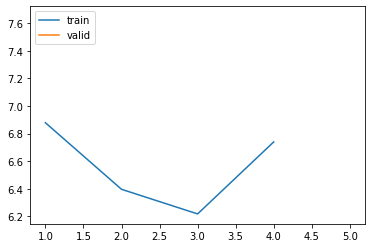

In [ ]:
#hide
learn.recorder.plot_loss(skip_start=1)

In [ ]:
#export
class FetchPreds(Callback):
    "A callback to fetch predictions during the training loop"
    def __init__(self, ds_idx=1, dl=None, with_input=False, with_decoded=False, cbs=None):
        self.cbs = L(cbs)
        store_attr(self, 'ds_idx,dl,with_input,with_decoded')

    def after_validate(self):
        with self.learn.removed_cbs(L(self, self.learn.recorder) + self.cbs) as learn:
            self.preds = learn.get_preds(ds_idx=self.ds_idx, dl=self.dl,
                with_input=self.with_input, with_decoded=self.with_decoded, inner=True)

## Inference functions

In [ ]:
show_doc(Learner.no_logging)

<h4 id="Learner.no_logging" class="doc_header"><code>Learner.no_logging</code><a href="__main__.py#L180" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.no_logging</code>()

Context manager to temporarily remove `logger`

In [ ]:
learn = synth_learner(n_train=5, metrics=tst_metric)
with learn.no_logging():
    test_stdout(lambda: learn.fit(1), '')
test_eq(learn.logger, print)

In [ ]:
show_doc(Learner.validate)

<h4 id="Learner.validate" class="doc_header"><code>Learner.validate</code><a href="__main__.py#L128" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.validate</code>(**`ds_idx`**=*`1`*, **`dl`**=*`None`*, **`cbs`**=*`None`*)

Validate on `dl` with potential new `cbs`.

In [ ]:
#Test result
learn = synth_learner(n_train=5, metrics=tst_metric)
res = learn.validate()
test_eq(res[0], res[1])
x,y = learn.dls.valid_ds.tensors
test_close(res[0], F.mse_loss(learn.model(x), y))

In [ ]:
#hide
#Test other dl
res = learn.validate(dl=learn.dls.train)
test_eq(res[0], res[1])
x,y = learn.dls.train_ds.tensors
test_close(res[0], F.mse_loss(learn.model(x), y))

#Test additional callback is executed.
cycle = cycle_events[:2] + ['begin_validate'] + batchv_events * 2 + cycle_events[-3:]
test_stdout(lambda: learn.validate(cbs=VerboseCallback()), '\n'.join(cycle))

In [ ]:
show_doc(Learner.loss_not_reduced)

<h4 id="Learner.loss_not_reduced" class="doc_header"><code>Learner.loss_not_reduced</code><a href="__main__.py#L185" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.loss_not_reduced</code>()

A context manager to evaluate `loss_func` with reduction set to none.

In [ ]:
#hide
test_eq(learn.loss_func.reduction, 'mean')
with learn.loss_not_reduced():
    test_eq(learn.loss_func.reduction, 'none')
    x,y = learn.dls.one_batch()
    p = learn.model(x)
    losses = learn.loss_func(p, y)
    test_eq(losses.shape, y.shape)
    test_eq(losses, F.mse_loss(p,y, reduction='none'))
test_eq(learn.loss_func.reduction, 'mean')

In [ ]:
show_doc(Learner.get_preds)

<h4 id="Learner.get_preds" class="doc_header"><code>Learner.get_preds</code><a href="__main__.py#L136" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.get_preds</code>(**`ds_idx`**=*`1`*, **`dl`**=*`None`*, **`with_input`**=*`False`*, **`with_decoded`**=*`False`*, **`with_loss`**=*`False`*, **`act`**=*`None`*, **`inner`**=*`False`*, **`save_preds`**=*`None`*, **`save_targs`**=*`None`*, **`concat_dim`**=*`0`*)

Get the predictions and targets on the `ds_idx`-th dbunchset or `dl`, optionally `with_input` and `with_loss`

Depending on the `loss_func` attribute of `Learner`, an activation function will be picked automatically so that the predictions make sense. For instance if the loss is a case of cross-entropy, a softmax will be applied, or if the loss is binary cross entropy with logits, a sigmoid will be applied. If you want to make sure a certain activation function is applied, you can pass it with `act`.

> Note: If you want to use the option `with_loss=True` on a custom loss function, make sure you have implemented a `reduction` attribute that supports 'none' 

In [ ]:
#Test result
learn = synth_learner(n_train=5, metrics=tst_metric)
preds,targs = learn.get_preds()
x,y = learn.dls.valid_ds.tensors
test_eq(targs, y)
test_close(preds, learn.model(x))

preds,targs = learn.get_preds(act = torch.sigmoid)
test_eq(targs, y)
test_close(preds, torch.sigmoid(learn.model(x)))

In [ ]:
#Test get_preds work with ds not evenly dividble by bs
learn = synth_learner(n_train=2.5, metrics=tst_metric)
preds,targs = learn.get_preds(ds_idx=0)

In [ ]:
#hide
#Test other dataset
x = torch.randn(16*5)
y = 2*x + 3 + 0.1*torch.randn(16*5)
dl = TfmdDL(TensorDataset(x, y), bs=16)
preds,targs = learn.get_preds(dl=dl)
test_eq(targs, y)
test_close(preds, learn.model(x))

#Test with loss
preds,targs,losses = learn.get_preds(dl=dl, with_loss=True)
test_eq(targs, y)
test_close(preds, learn.model(x))
test_close(losses, F.mse_loss(preds, targs, reduction='none'))

#Test with inputs
inps,preds,targs = learn.get_preds(dl=dl, with_input=True)
test_eq(inps,x)
test_eq(targs, y)
test_close(preds, learn.model(x))

In [ ]:
#hide
#Test with no target
learn = synth_learner(n_train=5)
x = torch.randn(16*5)
dl = TfmdDL(TensorDataset(x), bs=16)
preds,targs = learn.get_preds(dl=dl)
assert targs is None

In [ ]:
#hide
#Test with targets that are tuples
def _fake_loss(x,y,z,reduction=None): return F.mse_loss(x,y)

learn = synth_learner(n_train=5)
x = torch.randn(16*5)
y = 2*x + 3 + 0.1*torch.randn(16*5)
learn.dls.n_inp=1
learn.loss_func = _fake_loss
dl = TfmdDL(TensorDataset(x, y, y), bs=16)
preds,targs = learn.get_preds(dl=dl)
test_eq(targs, [y,y])

In [ ]:
#hide
#Test with inputs that are tuples
class _TupleModel(Module):
    def __init__(self, model): self.model=model
    def forward(self, x1, x2): return self.model(x1)

learn = synth_learner(n_train=5)
#learn.dls.n_inp=2
x = torch.randn(16*5)
y = 2*x + 3 + 0.1*torch.randn(16*5)
learn.model = _TupleModel(learn.model)
learn.dls = DataLoaders(TfmdDL(TensorDataset(x, x, y), bs=16),TfmdDL(TensorDataset(x, x, y), bs=16))
inps,preds,targs = learn.get_preds(ds_idx=0, with_input=True)
test_eq(inps, [x,x])

In [ ]:
#hide
#Test auto activation function is picked
learn = synth_learner(n_train=5)
learn.loss_func = BCEWithLogitsLossFlat()
x = torch.randn(16*5)
y = 2*x + 3 + 0.1*torch.randn(16*5)
dl = TfmdDL(TensorDataset(x, y), bs=16)
preds,targs = learn.get_preds(dl=dl)
test_close(preds, torch.sigmoid(learn.model(x)))

In [ ]:
inps,preds,targs = learn.get_preds(ds_idx=0, with_input=True)
tst = learn.get_preds(ds_idx=0, with_input=True, with_decoded=True)

In [ ]:
show_doc(Learner.predict)

<h4 id="Learner.predict" class="doc_header"><code>Learner.predict</code><a href="__main__.py#L157" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.predict</code>(**`item`**, **`rm_type_tfms`**=*`None`*, **`with_input`**=*`False`*)

Return the prediction on `item`, fully decoded, loss function decoded and probabilities

It returns a tuple of three elements with, in reverse order,
- the prediction from the model, potentially passed through the activation of the loss function (if it has one)
- the decoded prediction, using the poential `decodes` method from it
- the fully decoded prediction, using the transforms used to buil the `Datasets`/`DataLoaders`

In [ ]:
class _FakeLossFunc(Module):
    reduction = 'none'
    def forward(self, x, y): return F.mse_loss(x,y)
    def activation(self, x): return x+1
    def decodes(self, x):    return 2*x

class _Add1(Transform):
    def encodes(self, x): return x+1
    def decodes(self, x): return x-1
    
learn = synth_learner(n_train=5)
dl = TfmdDL(Datasets(torch.arange(50), tfms = [L(), [_Add1()]]))
learn.dls = DataLoaders(dl, dl)
learn.loss_func = _FakeLossFunc()

inp = tensor([2.])
out = learn.model(inp).detach()+1  #applying model + activation
dec = 2*out                        #decodes from loss function
full_dec = dec-1                   #decodes from _Add1
test_eq(learn.predict(inp), [full_dec,dec,out])
test_eq(learn.predict(inp, with_input=True), [inp,full_dec,dec,out])

## Transfer learning

In [ ]:
#export
@patch
def freeze_to(self:Learner, n):
    if self.opt is None: self.create_opt()
    self.opt.freeze_to(n)
    self.opt.clear_state()

@patch
def freeze(self:Learner): self.freeze_to(-1)

@patch
def unfreeze(self:Learner): self.freeze_to(0)

add_docs(Learner,
         freeze_to="Freeze parameter groups up to `n`",
         freeze="Freeze up to last parameter group",
         unfreeze="Unfreeze the entire model")

In [ ]:
#hide
class _TstModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
        self.tst = nn.Sequential(nn.Linear(4,5), nn.BatchNorm1d(3))
        self.tst[0].bias.data,self.tst[1].bias.data = torch.randn(5),torch.randn(3) 
    def forward(self, x): return x * self.a + self.b
    
class _PutGrad(Callback):
    def after_backward(self):
        for p in self.learn.model.tst.parameters():
            if p.requires_grad: p.grad = torch.ones_like(p.data)

def _splitter(m): return [list(m.tst[0].parameters()), list(m.tst[1].parameters()), [m.a,m.b]]
            
learn = synth_learner(n_train=5, opt_func = partial(SGD), cbs=_PutGrad, splitter=_splitter, lr=1e-2)
learn.model = _TstModel()
learn.freeze()
init = [p.clone() for p in learn.model.tst.parameters()]
learn.fit(1, wd=0.)
end = list(learn.model.tst.parameters())
#linear was not trained
for i in [0,1]: test_close(end[i],init[i])
#bn was trained even frozen since `train_bn=True` by default
for i in [2,3]: test_close(end[i]-init[i], -0.05 * torch.ones_like(end[i]))

(#4) [0,11.799610137939453,10.590188980102539,'00:00']


In [ ]:
#hide
learn = synth_learner(n_train=5, opt_func = partial(SGD), cbs=_PutGrad, splitter=_splitter, train_bn=False, lr=1e-2)
learn.model = _TstModel()
learn.freeze()
init = [p.clone() for p in learn.model.tst.parameters()]
learn.fit(1, wd=0.)
end = list(learn.model.tst.parameters())
#linear and bn were not trained
for i in range(4): test_close(end[i],init[i])

learn.freeze_to(-2)
init = [p.clone() for p in learn.model.tst.parameters()]
learn.fit(1, wd=0.)
end = list(learn.model.tst.parameters())
#linear was not trained
for i in [0,1]: test_close(end[i],init[i])
#bn was trained 
for i in [2,3]: test_close(end[i]-init[i], -0.05 * torch.ones_like(end[i]))
    
learn.unfreeze()
init = [p.clone() for p in learn.model.tst.parameters()]
learn.fit(1, wd=0.)
end = list(learn.model.tst.parameters())
#linear and bn were trained
for i in range(4): test_close(end[i]-init[i], -0.05 * torch.ones_like(end[i]), 1e-3)

(#4) [0,9.322746276855469,9.645425796508789,'00:00']
(#4) [0,7.677485942840576,7.942889213562012,'00:00']
(#4) [0,6.342437267303467,6.541775703430176,'00:00']


## Exporting a `Learner`

In [ ]:
#export
@patch
def export(self:Learner, fname='export.pkl'):
    "Export the content of `self` without the items and the optimizer state for inference"
    if rank_distrib(): return # don't export if slave proc
    old_dbunch = self.dls
    self.dls = self.dls.new_empty()
    state = self.opt.state_dict()
    self.opt = None
    with warnings.catch_warnings():
        #To avoid the warning that come from PyTorch about model not being checked
        warnings.simplefilter("ignore")
        torch.save(self, self.path/fname)
    self.create_opt()
    self.opt.load_state_dict(state)
    self.dls = old_dbunch

In [ ]:
#export
def load_learner(fname, cpu=True):
    "Load a `Learner` object in `fname`, optionally putting it on the `cpu`"
    res = torch.load(fname, map_location='cpu' if cpu else None)
    if hasattr(res, 'to_fp32'): res = res.to_fp32()
    if cpu: res.dls.cpu()
    return res

## TTA

In [ ]:
#export
@patch
def tta(self:Learner, ds_idx=1, dl=None, n=4, item_tfms=None, batch_tfms=None, beta=0.25, use_max=False):
    "Return predictions on the `ds_idx` dataset or `dl` using Test Time Augmentation"
    if dl is None: dl = self.dls[ds_idx]
    if item_tfms is not None or batch_tfms is not None: dl = dl.new(after_item=item_tfms, after_batch=batch_tfms)
    with dl.dataset.set_split_idx(0), self.no_mbar():
        if hasattr(self,'progress'): self.progress.mbar = master_bar(list(range(n)))
        aug_preds = []
        for i in self.progress.mbar if hasattr(self,'progress') else range(n):
            self.epoch = i #To keep track of progress on mbar since the progress callback will use self.epoch
            aug_preds.append(self.get_preds(ds_idx, inner=True)[0][None])
    aug_preds = torch.cat(aug_preds)
    aug_preds = aug_preds.max(0)[0] if use_max else aug_preds.mean(0)
    self.epoch = n
    with dl.dataset.set_split_idx(1): preds,targs = self.get_preds(ds_idx, inner=True)
    if use_max: return torch.stack([preds, aug_preds], 0).max(0)[0],targs
    preds = (aug_preds,preds) if beta is None else torch.lerp(aug_preds, preds, beta)
    return preds,targs

In practice, we get the predictions `n` times with the transforms of the training set and average those. The final predictions are `(1-beta)` multiplied by this average + `beta` multiplied by the predictions obtained with the transforms of the dataset. Set `beta` to `None` to get a tuple of the predictions and tta results.

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 19_callback.mixup.ipynb.
Converted 20_interpret.ipynb.
Converted 20a_distributed.ipynb.
Converted 21_vision.learner.ipynb.
Converted 22_tutorial.ima